In [ ]:
#XGboost
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 1. Load the dataset
df = pd.read_csv('data1.csv')
X = df.drop('Class', axis=1)
y = df['Class']

# 2. Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Initialize XGBoost with GPU support
model = xgb.XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    use_label_encoder=False,
)

# 4. Train the model
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

# 5. Predict probabilities and apply custom threshold
prob_preds = model.predict_proba(X_test)[:, 1]
threshold = 0.25
class_preds = (prob_preds > threshold).astype(int)

# 6. Evaluate the results
accuracy = accuracy_score(y_test, class_preds)
print(f"Test Accuracy (threshold=0.25): {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, class_preds))


[0]	validation_0-logloss:0.09428
[1]	validation_0-logloss:0.06912
[2]	validation_0-logloss:0.05107
[3]	validation_0-logloss:0.03799
[4]	validation_0-logloss:0.02848
[5]	validation_0-logloss:0.02150
[6]	validation_0-logloss:0.01634
[7]	validation_0-logloss:0.01260
[8]	validation_0-logloss:0.00983
[9]	validation_0-logloss:0.00782
[10]	validation_0-logloss:0.00633
[11]	validation_0-logloss:0.00528
[12]	validation_0-logloss:0.00449
[13]	validation_0-logloss:0.00390
[14]	validation_0-logloss:0.00348
[15]	validation_0-logloss:0.00314
[16]	validation_0-logloss:0.00290
[17]	validation_0-logloss:0.00273
[18]	validation_0-logloss:0.00262
[19]	validation_0-logloss:0.00253
[20]	validation_0-logloss:0.00246
[21]	validation_0-logloss:0.00242
[22]	validation_0-logloss:0.00237
[23]	validation_0-logloss:0.00234


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:43:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:43:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[24]	validation_0-logloss:0.00231
[25]	validation_0-logloss:0.00232
[26]	validation_0-logloss:0.00230
[27]	validation_0-logloss:0.00231
[28]	validation_0-logloss:0.00231
[29]	validation_0-logloss:0.00234
[30]	validation_0-logloss:0.00233
[31]	validation_0-logloss:0.00232
[32]	validation_0-logloss:0.00234
[33]	validation_0-logloss:0.00234
[34]	validation_0-logloss:0.00235
[35]	validation_0-logloss:0.00235
[36]	validation_0-logloss:0.00237
[37]	validation_0-logloss:0.00236
[38]	validation_0-logloss:0.00237
[39]	validation_0-logloss:0.00238
[40]	validation_0-logloss:0.00240
[41]	validation_0-logloss:0.00240
[42]	validation_0-logloss:0.00241
[43]	validation_0-logloss:0.00242
[44]	validation_0-logloss:0.00243
[45]	validation_0-logloss:0.00243
[46]	validation_0-logloss:0.00245
[47]	validation_0-logloss:0.00246
[48]	validation_0-logloss:0.00246
[49]	validation_0-logloss:0.00247
[50]	validation_0-logloss:0.00247
[51]	validation_0-logloss:0.00247
[52]	validation_0-logloss:0.00249
[53]	validatio

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:43:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [100]:
#Below is the final
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import recall_score, precision_score
import xgboost as xgb

# Step 0: Add 'index' column as the first column
data = pd.read_csv('data1.csv')
data.insert(0, 'index', range(len(data)))  # Add index column at the start

# Step 1: Split into train (60%), test1 (20%), test2 (20%) with stratification
train, temp = train_test_split(
    data, test_size=0.4, stratify=data['Class'], random_state=43
)
test1, test2 = train_test_split(
    temp, test_size=0.5, stratify=temp['Class'], random_state=28
)

# Step 2: Split train into 6 equal, non-overlapping stratified subsets
n_subsets = 6
skf = StratifiedKFold(n_splits=n_subsets, shuffle=True, random_state=42)
subsets = []
for i, (_, idx) in enumerate(skf.split(train, train['Class'])):
    subset = train.iloc[idx].copy()
    subset['subset'] = f'sub{i+1}'
    subsets.append(subset)

# Prepare to collect tough frauds and legits from all validation subsets
# Remove easy frauds
T = 0.8 #top limit for easy fraud probability
# Remove easy legits
B = 0.4 # lower limit for fraud probability for easy legit.
# Now, apply oversampling with initial lambda values, using per-instance recall/precision
lamda_1 = 1000 #(greater than 10 will give greater than 10 and lower than 100 integer)
lamda_2 = 100
fnlt= 0.5 # flase-negative(fraud not cuaght) lower threshol for taugh flase-negative
fput= 0.9 # false-positive(legit wrong caught) higher threshold for taugh false-positive.
target_fraud_ratio = 0.5

all_fn_rows = []
all_fn_probs = []
all_fn_recalls = []
all_fp_rows = []
all_fp_probs = []
all_fp_precisions = []
all_val_sub = []
#all_hf_rows = []  # To store oversampled hard frauds

for val_idx in range(n_subsets):
    # Select training and validation subsets
    train_subs = pd.concat([subsets[i] for i in range(n_subsets) if i != val_idx], ignore_index=True)
    val_sub = subsets[val_idx].copy()

    X_train = train_subs.drop(['Class', 'index', 'subset'], axis=1)
    y_train = train_subs['Class']
    X_val = val_sub.drop(['Class', 'index', 'subset'], axis=1)
    y_val = val_sub['Class']

    model = xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    # Calculate recall and precision for this fold (on remaining val_sub)
    fold_recall = recall_score(y_val, y_pred, zero_division=0)
    fold_precision = precision_score(y_val, y_pred, zero_division=0)

    # Remove easy frauds

    y_pred = pd.Series(y_pred, index=val_sub.index)
    y_proba = pd.Series(y_proba, index=val_sub.index)
    easy_frauds_idx = val_sub[(y_proba > T) & (y_val == 1)].index
    print(f'easy frauds removed {val_idx}: {easy_frauds_idx.shape}')
    val_sub = val_sub.drop(easy_frauds_idx)
    y_val = y_val.drop(easy_frauds_idx)
    y_pred = y_pred.drop(easy_frauds_idx)
    y_proba = y_proba.drop(easy_frauds_idx)


    # Remove easy legits

    easy_legits_idx = val_sub[(y_proba < B) & (y_val == 0)].index
    print(f'easy legits {val_idx}: {easy_legits_idx.shape}')
    val_sub = val_sub.drop(easy_legits_idx)
    y_val = y_val.drop(easy_legits_idx)
    y_pred = y_pred.drop(easy_legits_idx)
    y_proba = y_proba.drop(easy_legits_idx)



    # Collect remaining (tough) false negatives and false positives
    false_negatives_idx = val_sub[(y_val == 1) & (y_pred == 0)].index
    fn_rows = val_sub.loc[false_negatives_idx].copy()
    fn_probs = y_proba.loc[false_negatives_idx]
    fn_rows['fold_recall'] = fold_recall  # Store per-fold recall with each row
    all_fn_rows.append(fn_rows)
    all_fn_probs.append(fn_probs)
    all_fn_recalls.append(pd.Series([fold_recall] * len(fn_rows), index=fn_rows.index))

    false_positives_idx = val_sub[(y_val == 0) & (y_pred == 1)].index
    fp_rows = val_sub.loc[false_positives_idx].copy()
    fp_probs = y_proba.loc[false_positives_idx]
    fp_rows['fold_precision'] = fold_precision  # Store per-fold precision with each row
    all_fp_rows.append(fp_rows)
    all_fp_probs.append(fp_probs)
    all_fp_precisions.append(pd.Series([fold_precision] * len(fp_rows), index=fp_rows.index))
    print(val_sub['Class'].value_counts())
    # Hard frauds: remaining frauds in val_sub that are not FNs
    #hard_fraud_idx = val_sub[(y_val == 1) & (y_pred == 1)].index
    #hard_fraud_rows = val_sub.loc[hard_fraud_idx].copy()
    #hard_fraud_probs = y_proba.loc[hard_fraud_idx]

    # Oversample using recall / predicted probability (no lambda)
    #hf_repeat = np.ceil(fold_recall / np.maximum(hard_fraud_probs, 0.1)).astype(int)
    #hf_oversampled = pd.DataFrame(np.repeat(hard_fraud_rows.values, hf_repeat, axis=0),columns=hard_fraud_rows.columns)
    # Store oversampled hard frauds
    #all_hf_rows.append(hf_oversampled)

    # Optionally, collect all remaining val_sub for analysis
    all_val_sub.append(val_sub)

# Combine all tough cases and their associated probabilities and metrics
all_fn_rows = pd.concat(all_fn_rows, ignore_index=True)
all_fn_probs = pd.concat(all_fn_probs, ignore_index=True)
all_fn_recalls = pd.concat(all_fn_recalls, ignore_index=True)
all_fp_rows = pd.concat(all_fp_rows, ignore_index=True)
all_fp_probs = pd.concat(all_fp_probs, ignore_index=True)
all_fp_precisions = pd.concat(all_fp_precisions, ignore_index=True)
all_val_sub = pd.concat(all_val_sub, ignore_index=True)
#all_hf_rows = pd.concat(all_hf_rows, ignore_index=True)

# Now, apply oversampling with initial lambda values, using per-instance recall/precision


fn_repeat = np.ceil(all_fn_recalls * lamda_1 / np.maximum(all_fn_probs, 0.1)).astype(int)
fn_oversampled = pd.DataFrame(
    np.repeat(all_fn_rows.values, fn_repeat, axis=0),
    columns=all_fn_rows.columns)

fp_repeat = np.ceil(all_fp_precisions * lamda_2 / np.maximum(all_fp_probs, 0.1)).astype(int)
fp_oversampled = pd.DataFrame(
    np.repeat(all_fp_rows.values, fp_repeat, axis=0),
    columns=all_fp_rows.columns)

# Oversample using recall / predicted probability (no lambda)
#hf_repeat = np.ceil(fold_recall / np.maximum(hard_fraud_probs, 0.1)).astype(int)
#hf_oversampled = pd.DataFrame(np.repeat(hard_fraud_rows.values, hf_repeat, axis=0),columns=hard_fraud_rows.columns)

def adjust_lambdas(train, test1, fn_oversampled, fp_oversampled,all_fn_rows, all_fn_probs, all_fn_recalls,
                   all_fp_rows, all_fp_probs, all_fp_precisions,
                   target_fraud_ratio):

    lam1, lam2 = lamda_1, lamda_2

    for _ in range(1):  # max 100 iterations
        # Recalculate oversampled sets with updated lambdas and per-instance recall/precision
        fn_repeat = np.ceil(all_fn_recalls * lam1 / np.maximum(all_fn_probs, fnlt)).astype(int)
        fn_oversampled = pd.DataFrame(
            np.repeat(all_fn_rows.values, fn_repeat, axis=0),
            columns=all_fn_rows.columns)

        fp_repeat = np.ceil(all_fp_precisions * lam2 / np.maximum(all_fp_probs, fput)).astype(int)
        fp_oversampled = pd.DataFrame(
            np.repeat(all_fp_rows.values, fp_repeat, axis=0),
            columns=all_fp_rows.columns)

        # Combine oversampled data
        oversampled_data = pd.concat([fn_oversampled, fp_oversampled], ignore_index=True)

        # Combine with original train and test1
        combined_dataset = pd.concat([train, test1, oversampled_data], ignore_index=True)

        # Calculate fraud ratio
        fraud_ratio = combined_dataset['Class'].mean()  # mean of binary Class = ratio of 1s

        # Check if it's close enough to target
        if abs(fraud_ratio - target_fraud_ratio) < 0.01:
            break

        # Adjust lambdas based on fraud ratio
        if fraud_ratio < target_fraud_ratio:
            lam1 += 1
        else:
            lam2 += 1

        lam1 = max(lam1, lamda_1)
        lam2 = max(lam2, lamda_2)

    return lam1, lam2, oversampled_data, fraud_ratio , combined_dataset




lamda_1, lamda_2, oversampled_final, fraud_ratio, combined_dataset = adjust_lambdas(train, test1, fn_oversampled, fp_oversampled,all_fn_rows,
                                                     all_fn_probs, all_fn_recalls,
                                                     all_fp_rows, all_fp_probs, all_fp_precisions,
                                                     target_fraud_ratio)








easy frauds removed 0: (32,)
easy legits 0: (28430,)
Class
1    17
0     2
Name: count, dtype: int64
easy frauds removed 1: (41,)
easy legits 1: (28428,)
Class
1    8
0    4
Name: count, dtype: int64
easy frauds removed 2: (39,)
easy legits 2: (28431,)
Class
1    10
0     1
Name: count, dtype: int64
easy frauds removed 3: (39,)
easy legits 3: (28429,)
Class
1    11
0     2
Name: count, dtype: int64
easy frauds removed 4: (35,)
easy legits 4: (28430,)
Class
1    14
0     1
Name: count, dtype: int64
easy frauds removed 5: (35,)
easy legits 5: (28429,)
Class
1    14
0     2
Name: count, dtype: int64


In [88]:
# Count hard frauds and hard legits in all_val_sub (not oversampled)
#hard_frauds = all_val_sub[all_val_sub['Class'] == 1]
#hard_legits = all_val_sub[all_val_sub['Class'] == 0]

# Count tough frauds (oversampled FNs)
tough_frauds_oversampled = len(fn_oversampled)
# Count tough positives (oversampled FPs)
tough_positives_oversampled = len(fp_oversampled)
# Count hard frauds not oversampled
hard_frauds_not_oversampled = len(hard_frauds)
# Count hard legits not oversampled
hard_legits_not_oversampled = len(hard_legits)

print("\n==================================")
print(f"\nFinal lamda_1: {lamda_1}, lamda_2: {lamda_2}")
print(f"Total samples remaing in train set after removing easy fraud and")
print(f"legits ;and adding tough fraud and tough positive: {len(oversampled_final)}")
print(f"Fraud ratio in resultant set: {oversampled_final['Class'].mean():.3f}")
print(f"Samples added by oversampling: {len(oversampled_final) - len(all_val_sub)}")
print(f"Tough fraud samples added by oversampling (False Negatives, FNs): {tough_frauds_oversampled}")
print(f"Tough positive samples added by oversampling (False Positives, FPs): {tough_positives_oversampled}")
print(f"Medium fraud samples added by oversampling: {len(all_hf_rows)}")

print(f"Medium legit samples (not oversampled): {hard_legits_not_oversampled}")
#print(final_balanced_df.shape)
print(oversampled_final['Class'].value_counts())
print("\n==================================")
print(f'fraud ratio: {fraud_ratio}')
print(f'oversampled: {oversampled_final.shape}')
print(f'')






Final lamda_1: 100, lamda_2: 33
Total samples remaing in train set after removing easy fraud and
legits ;and adding tough fraud and tough positive: 10147
Fraud ratio in resultant set: 0.967
Samples added by oversampling: 10061
Tough fraud samples added by oversampling (False Negatives, FNs): 47150
Tough positive samples added by oversampling (False Positives, FPs): 395
Medium fraud samples added by oversampling: 238
Medium legit samples (not oversampled): 45
Class
1    9811
0     336
Name: count, dtype: int64

fraud ratio: 0.04287539076943763
oversampled: (10147, 35)



In [89]:
combined_dataset.shape

(237992, 35)

In [90]:
# Prepare the final dataset by combining everything
final_oversampled_df = pd.concat([combined_dataset], ignore_index=True)

# Drop helper columns if needed
final_oversampled_df  = final_oversampled_df .drop(columns=[col for col in ['fold_recall', 'fold_precision', 'index', 'subset'] if col in final_oversampled_df.columns])

# Convert all columns to numeric
for col in final_oversampled_df.columns:
    final_oversampled_df [col] = pd.to_numeric(final_oversampled_df[col], errors='coerce')  # convert, set invalid entries to NaN
# Optionally drop rows with NaNs if any were introduced
final_oversampled_df = final_oversampled_df.dropna()
df_new = final_oversampled_df.copy()

In [91]:
#down is final ensembled model and up is final data seperation and oversampling

In [99]:
#this is the final ensemble model
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib



threshold = 0.5 #threshold for both, oversmpled and non over sampled.

# 2. Combine 'train' and 'test1' for Model 1 training for comparison
train_model1 = pd.concat([train, test1], ignore_index=True)

# Separate features (X) and target (y) for Model 1 training
X_train_model1 = train_model1.drop('Class', axis=1)
y_train_model1 = train_model1['Class']

# Separate features (X) and target (y) for Model 2 training
train_model2 = pd.concat([df_new], ignore_index=True)
X_train_model2 = train_model2.drop('Class', axis=1)
y_train_model2 = train_model2['Class']

# Separate features (X) and target (y) for test2 (final evaluation)
X_test2 = test2.drop('Class', axis=1)
y_test2 = test2['Class']

# Ensure 'index' column is dropped if present in any of the relevant DataFrames
for df_to_clean in [X_train_model1, X_train_model2, X_test2]:
    if 'index' in df_to_clean.columns:
        df_to_clean.drop('index', axis=1, inplace=True)

# Ensure data types are suitable for XGBoost and other models
X_train_model1 = X_train_model1.astype(float)
y_train_model1 = y_train_model1.astype(float)
X_train_model2 = X_train_model2.astype(float)
y_train_model2 = y_train_model2.astype(float)
X_test2 = X_test2.astype(float)
y_test2 = y_test2.astype(float)

# 3. Initialize and train the first XGBoost model (Model 1) on train_model1 without over sampling
model1 = xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='logloss', random_state=42)
model1.fit(X_train_model1, y_train_model1)



# 3.1. Predict probabilities and apply custom threshold
prob_preds1 = model1.predict_proba(X_test2)[:, 1]

class_preds1 = (prob_preds1 > threshold).astype(int)

# 6. Evaluate the results

print(f"Test Accuracy1: {accuracy_score(y_test2, class_preds1):.4f}")
print("\nClassification Report without oversampling:\n", classification_report(y_test2, class_preds1))




# 7. Initialize and train the second model (Meta-model) on the meta-model training data with over sampling
model2= xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='logloss', random_state=42)
model2.fit(X_train_model2, y_train_model2)





# 3.1. Predict probabilities and apply custom threshold
prob_preds2 = model2.predict_proba(X_test2)[:, 1]
class_preds2 = (prob_preds2 > threshold).astype(int)

# 6. Evaluate the results

print(f"Test Accuracy2: {accuracy_score(y_test2, class_preds2):.4f}")
print("\nClassification Report with oversampling:\n", classification_report(y_test2, class_preds2))


Test Accuracy1: 0.9995

Classification Report without oversampling:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       0.93      0.78      0.85        99

    accuracy                           1.00     56962
   macro avg       0.96      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Test Accuracy2: 0.9995

Classification Report with oversampling:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       0.93      0.79      0.85        99

    accuracy                           1.00     56962
   macro avg       0.96      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [60]:
# ... (rest of your code for splitting data, training model1 and meta_model)

# 7. Generate predictions (probabilities) from Model 1 on test2 (for final evaluation)
model1_preds_test2 = model1.predict_proba(X_test2)[:, 1]

# 8. Create the dataset for the meta-model's prediction (on test2)
X_meta_test = pd.DataFrame(model1_preds_test2, columns=['model1_prob'])

threshold = 0.6

# 9. Make final predictions with the Meta-model on test2 (you already have this)
final_predictions_prob = meta_model.predict_proba(X_meta_test)[:, 1]
final_predictions_class = (final_predictions_prob > threshold).astype(int)

# 10. Evaluate the final ensemble results on test2
# Calculate the AUC score for the ensemble model (meta-model) on test2 data.
auc = roc_auc_score(y_test2, meta_model.predict_proba(X_meta_test)[:, 1]) # Use X_meta_test here
print("AUC:", auc)

# ... (rest of your evaluation code for accuracy, confusion matrix, and classification report)


AUC: 0.8787614995957856



Classification Report on test2:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       0.96      0.76      0.85        99

    accuracy                           1.00     56962
   macro avg       0.98      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix on test2:
 [[56860     3]
 [   24    75]]

Classification Report on test2:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       0.96      0.76      0.85        99

    accuracy                           1.00     56962
   macro avg       0.98      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC: 0.8787614995957856


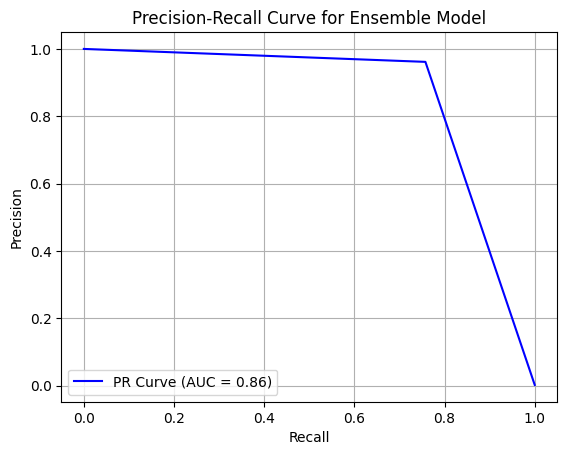

In [64]:
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc, roc_auc_score)
# Apply your custom threshold for final classification
#threshold = 0.5 # Or your desired threshold
final_predictions_class = (final_predictions_prob > threshold).astype(int)



print("\nClassification Report on test2:\n", classification_report(y_test2, final_predictions_class))


# Calculate and print the confusion matrix on test2
cm = confusion_matrix(y_test2, (final_predictions_prob > 0.15).astype(int)) # Use 0.15 threshold for confusion matrix
print("\nConfusion Matrix on test2:\n", cm)

print("\nClassification Report on test2:\n", classification_report(y_test2, (final_predictions_prob > 0.5).astype(int))) # Use 0.15 threshold for classification report

# Calculate the AUC score for the ensemble model (meta-model) on test2 data.
# Use a different variable name for the ROC AUC score
roc_auc = roc_auc_score(y_test2, final_predictions_prob)  # Renamed 'auc' to 'roc_auc'
print("ROC AUC:", roc_auc) # Print 'ROC AUC'

# 11. Draw the Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test2, final_predictions_prob)

pr_auc = auc(recall, precision)

# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})', color='blue')# Use the original auc function
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Ensemble Model")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

Before SMOTE: Counter({0: 227451, 1: 394})
After SMOTE: Counter({0: 227451, 1: 227451})

SMOTE added 227057 synthetic samples.
Accuracy: 0.999403110845827

Confusion Matrix:
 [[56843    21]
 [   13    85]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.87      0.83        98

    accuracy                           1.00     56962
   macro avg       0.90      0.93      0.92     56962
weighted avg       1.00      1.00      1.00     56962



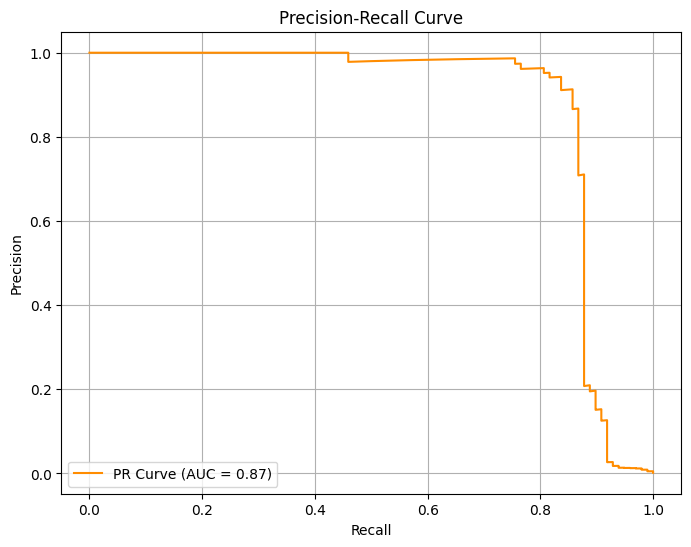

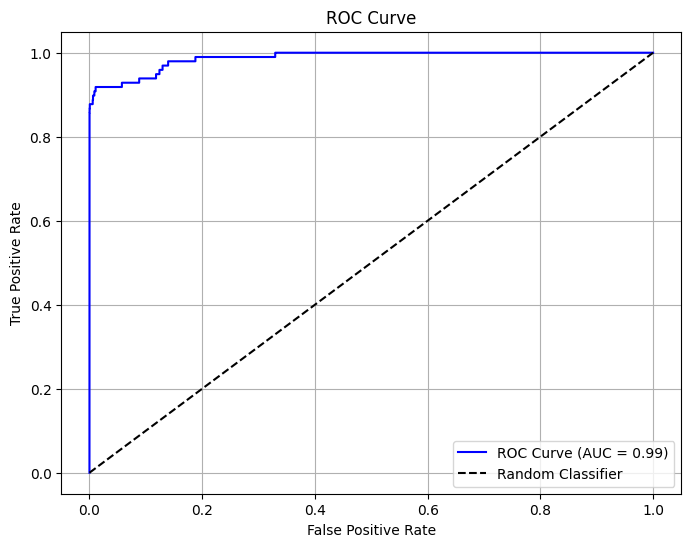

In [66]:
#smote for co
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc, roc_auc_score
)
from imblearn.over_sampling import SMOTE, ADASYN
import xgboost as xgb
import matplotlib.pyplot as plt

# Load data
data1 = pd.read_csv('data1.csv')

# Prepare features and target
X = data1.drop('Class', axis=1)
y = data1['Class']

# Split before SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=58, stratify=y)

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


# Show class distribution before and after SMOTE
from collections import Counter

print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_res))

# Calculate how many synthetic samples were added
added_samples = len(y_train_res) - len(y_train)
print(f"\nSMOTE added {added_samples} synthetic samples.")




# Train XGBoost classifier with GPU
clf = xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='logloss', random_state=42)
clf.fit(X_train_res, y_train_res)

# Predict on test set
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]  # Needed for curves

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})', color='darkorange')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Before ADASYN: Counter({0: 227451, 1: 394})
After ADASYN: Counter({1: 227480, 0: 227451})

ADASYN added 227086 synthetic samples.
Accuracy: 0.999385555282469

Confusion Matrix:
 [[56843    21]
 [   14    84]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.86      0.83        98

    accuracy                           1.00     56962
   macro avg       0.90      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962



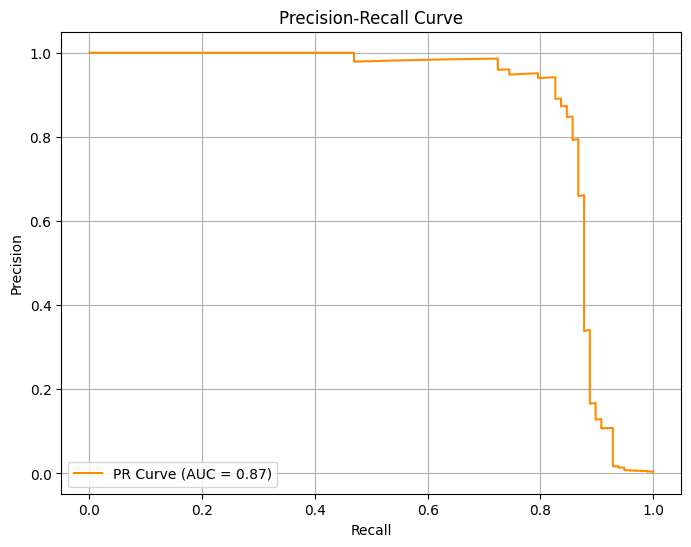

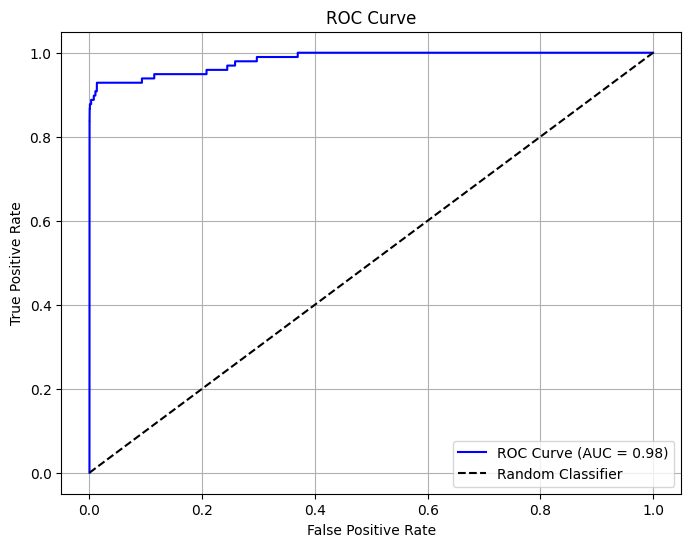

In [67]:
#ADASYN
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc, roc_auc_score
)
from imblearn.over_sampling import ADASYN  # Use ADASYN instead of SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt

# Load data
data1 = pd.read_csv('data1.csv')

# Prepare features and target
X = data1.drop('Class', axis=1)
y = data1['Class']

# Split before oversampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=58, stratify=y)

# Apply ADASYN to training data only
adasyn = ADASYN(random_state=42)
X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)

# Show class distribution before and after ADASYN
from collections import Counter

print("Before ADASYN:", Counter(y_train))
print("After ADASYN:", Counter(y_train_res))

# Calculate how many synthetic samples were added
added_samples = len(y_train_res) - len(y_train)
print(f"\nADASYN added {added_samples} synthetic samples.")

# Train XGBoost classifier with GPU
clf = xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='logloss', random_state=42)
clf.fit(X_train_res, y_train_res)

# Predict on test set
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]  # Needed for curves

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})', color='darkorange')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


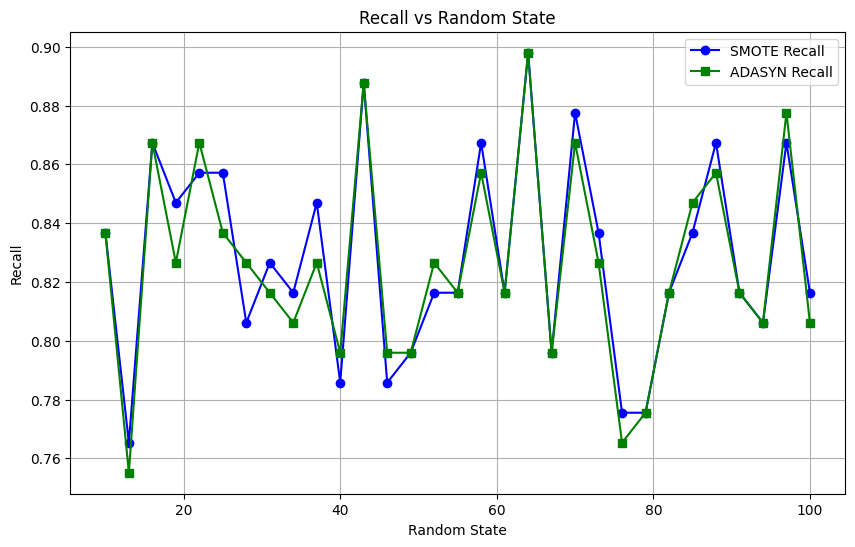

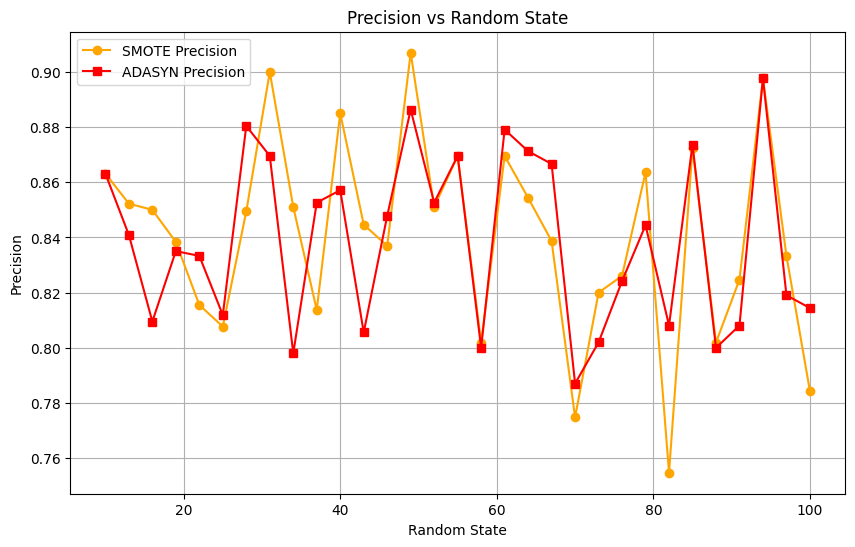

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from imblearn.over_sampling import SMOTE, ADASYN
import xgboost as xgb
from collections import Counter

# Load data
data1 = pd.read_csv('data1.csv')

# Prepare features and target
X = data1.drop('Class', axis=1)
y = data1['Class']

# Ranges of random states
random_states = range(10, 101, 3)

# Store results
recalls_smote, recalls_adasyn = [], []
precisions_smote, precisions_adasyn = [], []

for rs in random_states:
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rs, stratify=y)

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X_train, y_train)

    # Apply ADASYN
    adasyn = ADASYN(random_state=42)
    X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

    # XGBoost classifier
    clf_smote = xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='logloss', random_state=42)
    clf_adasyn = xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='logloss', random_state=42)

    # Fit models
    clf_smote.fit(X_smote, y_smote)
    clf_adasyn.fit(X_adasyn, y_adasyn)

    # Predict
    y_pred_smote = clf_smote.predict(X_test)
    y_pred_adasyn = clf_adasyn.predict(X_test)

    # Evaluate
    recall_sm = recall_score(y_test, y_pred_smote)
    precision_sm = precision_score(y_test, y_pred_smote)

    recall_ad = recall_score(y_test, y_pred_adasyn)
    precision_ad = precision_score(y_test, y_pred_adasyn)

    recalls_smote.append(recall_sm)
    recalls_adasyn.append(recall_ad)
    precisions_smote.append(precision_sm)
    precisions_adasyn.append(precision_ad)

# Plot Recall
plt.figure(figsize=(10, 6))
plt.plot(random_states, recalls_smote, label='SMOTE Recall', marker='o', color='blue')
plt.plot(random_states, recalls_adasyn, label='ADASYN Recall', marker='s', color='green')
plt.xlabel("Random State")
plt.ylabel("Recall")
plt.title("Recall vs Random State")
plt.legend()
plt.grid(True)
plt.show()

# Plot Precision
plt.figure(figsize=(10, 6))
plt.plot(random_states, precisions_smote, label='SMOTE Precision', marker='o', color='orange')
plt.plot(random_states, precisions_adasyn, label='ADASYN Precision', marker='s', color='red')
plt.xlabel("Random State")
plt.ylabel("Precision")
plt.title("Precision vs Random State")
plt.legend()
plt.grid(True)
plt.show()


Final Ensemble Model Accuracy on test2: 0.9996

Confusion Matrix on test2:
 [[56859     4]
 [   19    80]]

Classification Report on test2:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       0.95      0.81      0.87        99

    accuracy                           1.00     56962
   macro avg       0.98      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962

AUC: 0.9776228066856419


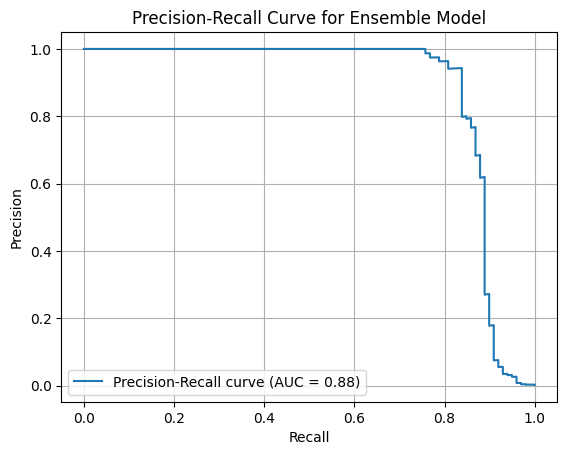

In [75]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib

# Assuming 'data' is your initial DataFrame

# 1. Split data into train, test1, and test2 sets
train, temp = train_test_split(
    data, test_size=0.4, stratify=data['Class'], random_state=42
)
test1, test2 = train_test_split(
    temp, test_size=0.5, stratify=temp['Class'], random_state=42
)

# Load your df_new data
df_new = pd.read_csv('data1.csv') # Replace with the actual path to your df_new

# 2. Combine 'train' and 'test1' for Model 1 training
train_model1 = pd.concat([train, test1], ignore_index=True)

# Separate features (X) and target (y) for Model 1 training
X_train_model1 = train_model1.drop('Class', axis=1)
y_train_model1 = train_model1['Class']

# Separate features (X) and target (y) for Model 2 training (using the original 'train' data after concatenation)
train_model2 = pd.concat([df_new, train], ignore_index=True)
X_train_model2 = train_model2.drop('Class', axis=1)
y_train_model2 = train_model2['Class']

# Separate features (X) and target (y) for test2 (final evaluation)
X_test2 = test2.drop('Class', axis=1)
y_test2 = test2['Class']

# Ensure 'index' column is dropped if present in any of the relevant DataFrames
for df_to_clean in [X_train_model1, X_train_model2, X_test2]:
    if 'index' in df_to_clean.columns:
        df_to_clean.drop('index', axis=1, inplace=True)

# Ensure data types are suitable for XGBoost and other models
X_train_model1 = X_train_model1.astype(float)
y_train_model1 = y_train_model1.astype(float)
X_train_model2 = X_train_model2.astype(float)
y_train_model2 = y_train_model2.astype(float)
X_test2 = X_test2.astype(float)
y_test2 = y_test2.astype(float)

# 3. Initialize and train the first XGBoost model (Model 1) on train_model1
model1 = xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='logloss', random_state=42)
model1.fit(X_train_model1, y_train_model1)

# 4. Generate predictions (probabilities) from Model 1 on the data used to train Model 2 (X_train_model2)
model1_preds_for_model2_training = model1.predict_proba(X_train_model2)[:, 1]

# 5. Create the dataset for the meta-model's training
X_meta_train = pd.DataFrame(model1_preds_for_model2_training, columns=['model1_prob'])
y_meta_train = y_train_model2  # The target for the meta-model is the true labels from X_train_model2

# 6. Initialize and train the second model (Meta-model) on the meta-model training data
meta_model = LogisticRegression(random_state=42)
meta_model.fit(X_meta_train, y_meta_train)

# 7. Generate predictions (probabilities) from Model 1 on test2 (for final evaluation)
model1_preds_test2 = model1.predict_proba(X_test2)[:, 1]

# 8. Create the dataset for the meta-model's prediction (on test2)
X_meta_test = pd.DataFrame(model1_preds_test2, columns=['model1_prob'])

# 9. Make final predictions with the Meta-model on test2
final_predictions_prob = meta_model.predict_proba(X_meta_test)[:, 1]

# 10. Evaluate the final ensemble results on test2
accuracy = accuracy_score(y_test2, (final_predictions_prob > 0.15).astype(int)) # Use 0.15 threshold for accuracy
print(f"Final Ensemble Model Accuracy on test2: {accuracy:.4f}")

# Calculate and print the confusion matrix on test2
cm = confusion_matrix(y_test2, (final_predictions_prob > 0.15).astype(int)) # Use 0.15 threshold for confusion matrix
print("\nConfusion Matrix on test2:\n", cm)

print("\nClassification Report on test2:\n", classification_report(y_test2, (final_predictions_prob > 0.15).astype(int))) # Use 0.15 threshold for classification report

# Calculate the AUC score for the ensemble model (meta-model) on test2 data.
auc_score = roc_auc_score(y_test2, final_predictions_prob) # Use final_predictions_prob
print("AUC:", auc_score)

# 11. Draw the Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test2, final_predictions_prob) # Use final_predictions_prob

# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc(recall, precision):.2f})') # Calculate AUC-PR for the curve
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Ensemble Model")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


In [ ]:
#up

In [ ]:
# Assuming you have loaded your data into 'train' and 'test2' DataFrames

# 1. Load the dataset
df = pd.read_csv('data1.csv')
X = df.drop('Class', axis=1)
y = df['Class']

# 2. Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42

# 3. Initialize XGBoost with GPU support
model = xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# 4. Predict probabilities and apply custom threshold
y_pred = model.predict(X_test)
prob_preds = model.predict_proba(X_test)[:, 1]
threshold = 0.15
class_preds = (prob_preds > threshold).astype(int)

# 5. Evaluate the results
accuracy = accuracy_score(y_test, class_preds)
print(f"Test Accuracy (threshold=0.25): {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, class_preds))


In [ ]:
# Assuming you have loaded your data into 'train' and 'test2' DataFrames

# 1. Prepare X_train and y_train
X_train = train.drop(['Class', 'index'], axis=1).astype(float) # Drop 'Class' and 'index'
y_train = train['Class'].astype(float)

# 2. Prepare X_test and y_test
X_test = test2.drop(['Class', 'index'], axis=1).astype(float)  # Drop 'Class' and 'index'
y_test = test2['Class'].astype(float)

# 3. Initialize XGBoost with GPU support
model = xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# 4. Predict probabilities and apply custom threshold
y_pred = model.predict(X_test)
prob_preds = model.predict_proba(X_test)[:, 1]
threshold = 0.15
class_preds = (prob_preds > threshold).astype(int)

# 5. Evaluate the results
accuracy = accuracy_score(y_test, class_preds)
print(f"Test Accuracy (threshold=0.25): {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, class_preds))


Test Accuracy (threshold=0.25): 0.9996

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       0.94      0.82      0.88        99

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
threshold = 0.10
class_preds = (prob_preds > threshold).astype(int)

# 5. Evaluate the results
accuracy = accuracy_score(y_test, class_preds)
print(f"Test Accuracy (threshold=0.25): {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, class_preds))


Test Accuracy (threshold=0.25): 0.9995

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       0.88      0.83      0.85        99

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
final_oversampled_df.head()
#Optional: Save to CSV
# final_balanced_df.to_csv("balanced_dataset.csv", index=False)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,140293.0,0.951025,3.252926,-5.039105,4.632411,3.014501,-1.34957,0.98094,-1.819539,-2.099049,...,1.404524,-0.760549,0.358292,-1.185942,-1.286177,0.000365,0.169662,0.108276,0.77,1
1,53316.0,-7.752965,0.705763,0.478148,3.985048,3.270238,1.01761,-10.758946,-8.702424,-0.164677,...,-5.729882,1.216213,-4.698273,-0.296797,-1.700717,0.156541,0.3693,0.075165,0.0,0
2,39729.0,-0.964567,-1.643541,-0.187727,1.158253,-2.458336,0.852222,2.785163,-0.303609,0.940006,...,0.44718,0.536204,1.634061,0.203839,0.218749,-0.221886,-0.308555,-0.1645,776.83,1
3,35261.0,-1.236842,1.94939,-1.139733,1.142948,-1.189765,-1.09756,-2.130852,0.701933,-1.488241,...,0.234634,-0.887139,-0.140437,-0.467764,0.041665,0.171172,0.865273,0.374717,2.69,0
4,166198.0,-35.548539,-31.850484,-48.325589,15.304184,-113.743307,73.301626,120.589494,-27.34736,-3.872425,...,-21.62012,5.712303,-1.581098,4.584549,4.554683,3.415636,31.612198,-15.430084,25691.16,0


In [ ]:
#XGboost
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 1. Load the dataset



# Optionally drop rows with NaNs if any were introduced
df = df.dropna()



X = test2.drop('Class', axis=1)
y = test2['Class']


)

# 3. Initialize XGBoost with GPU support
model = xgb.XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    use_label_encoder=False,
)

# 4. Train the model
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

# 5. Predict probabilities and apply custom threshold
prob_preds = model.predict_proba(X_test)[:, 1]
threshold = 0.25
class_preds = (prob_preds > threshold).astype(int)

# 6. Evaluate the results
accuracy = accuracy_score(y_test, class_preds)
print(f"Test Accuracy (threshold=0.25): {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, class_preds))


In [ ]:
#XGboost
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 1. Load the dataset



# Optionally drop rows with NaNs if any were introduced
df = df.dropna()



X = df.drop('Class', axis=1)
y = df['Class']

# 2. Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Initialize XGBoost with GPU support
model = xgb.XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    use_label_encoder=False,
)

# 4. Train the model
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

# 5. Predict probabilities and apply custom threshold
prob_preds = model.predict_proba(X_test)[:, 1]
threshold = 0.25
class_preds = (prob_preds > threshold).astype(int)

# 6. Evaluate the results
accuracy = accuracy_score(y_test, class_preds)
print(f"Test Accuracy (threshold=0.25): {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, class_preds))


[0]	validation_0-logloss:0.12036
[1]	validation_0-logloss:0.08878
[2]	validation_0-logloss:0.06634
[3]	validation_0-logloss:0.04998
[4]	validation_0-logloss:0.03891
[5]	validation_0-logloss:0.03019
[6]	validation_0-logloss:0.02375
[7]	validation_0-logloss:0.01904
[8]	validation_0-logloss:0.01553
[9]	validation_0-logloss:0.01284
[10]	validation_0-logloss:0.01074
[11]	validation_0-logloss:0.00890
[12]	validation_0-logloss:0.00773
[13]	validation_0-logloss:0.00661
[14]	validation_0-logloss:0.00590
[15]	validation_0-logloss:0.00531
[16]	validation_0-logloss:0.00483
[17]	validation_0-logloss:0.00446
[18]	validation_0-logloss:0.00404
[19]	validation_0-logloss:0.00378
[20]	validation_0-logloss:0.00348


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:50:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:50:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[21]	validation_0-logloss:0.00322
[22]	validation_0-logloss:0.00312
[23]	validation_0-logloss:0.00286
[24]	validation_0-logloss:0.00269
[25]	validation_0-logloss:0.00258
[26]	validation_0-logloss:0.00249
[27]	validation_0-logloss:0.00242
[28]	validation_0-logloss:0.00237
[29]	validation_0-logloss:0.00231
[30]	validation_0-logloss:0.00226
[31]	validation_0-logloss:0.00219
[32]	validation_0-logloss:0.00213
[33]	validation_0-logloss:0.00209
[34]	validation_0-logloss:0.00202
[35]	validation_0-logloss:0.00196
[36]	validation_0-logloss:0.00191
[37]	validation_0-logloss:0.00186
[38]	validation_0-logloss:0.00184
[39]	validation_0-logloss:0.00181
[40]	validation_0-logloss:0.00181
[41]	validation_0-logloss:0.00179
[42]	validation_0-logloss:0.00175
[43]	validation_0-logloss:0.00174
[44]	validation_0-logloss:0.00173
[45]	validation_0-logloss:0.00171
[46]	validation_0-logloss:0.00169
[47]	validation_0-logloss:0.00168
[48]	validation_0-logloss:0.00168
[49]	validation_0-logloss:0.00166
[50]	validatio

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:50:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
